In [1]:
import pandas as pd 
import numpy as np 
from PIL import Image as I
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data
from skimage import filters
from skimage import exposure
from sklearn.cluster import KMeans as km 
import cv2
import math

In [2]:
horse = I.open(r'../horse1-2.jpg')
df = np.array(horse)
grey_horse = horse.convert('L')
df_grey = np.array(grey_horse)

Other edge-detection methods sometimes broaden edges due to the way in which the edges are calculated, and are also sensitive to noise, as we saw in question 2, especially with higher thresholds of the Sobel method. 

Thus, for the rest of this question, as instructed, I will be following along with the instructions to code Canny's algorithm for edge detection.

# Part A

As instructed, I use a Guassian filter to blur, or smooth the image, which will help smooth over some of the noise causing distinct edges, like in the grass. Using a kernel and convolution, the smoothed array is created, and the image is shown for reference to see how the smoothing performed:

In [3]:
smoothing_filter = np.array([[1,4,7,10,7,4,1],[4,12,26,33,26,12,4],[7,26,55,71,55,26,7],[10,33,71,91,71,33,10],[7,26,55,71,55,26,7],[4,12,26,33,26,12,4],[1,4,7,10,7,4,1]])/1115

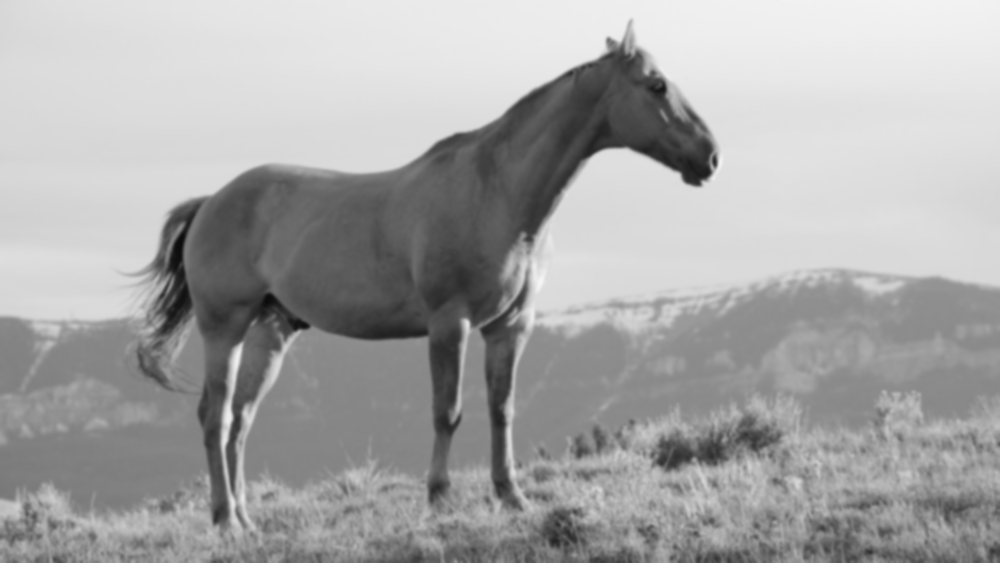

In [4]:
smooth_df = cv2.filter2D(df_grey,-1,smoothing_filter)
I.fromarray(smooth_df)

# Part B

Next, with the smoothed image becoming our new base image to detect edges on, the gradient magnitude and gradient directions must be calculated using the following functions given in the homework: 

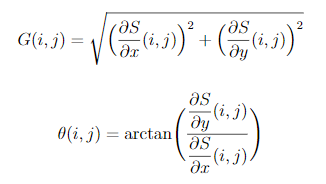
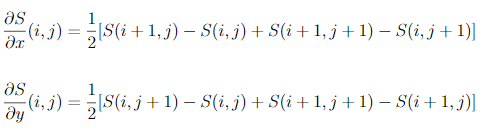


Notice that, while the equations call for partial derivatives, we can instead calculate an approximate discrete formula for each partial derivative, which are then used in the gradient functions.

In [5]:
def dSx(arr,i,j):
    return .5*(arr[i+1,j] - arr[i,j] + arr[i+1,j+1] - arr[i,j+1])

def dSy(arr,i,j):
    return .5*(arr[i,j+1] - arr[i,j] + arr[i+1,j+1] - arr[i+1,j])

def G(arr,i,j):
    return np.sqrt(dSx(arr,i,j)**2 + dSy(arr,i,j)**2)

def theta(arr,i,j):
    return math.atan(dSy(arr,i,j)/dSx(arr,i,j))

To be able to perform the calculations necessary, the array has to be padded with 0s, hence the padded array created below. This array will then be passed into for loops, with each cell passing through either the G or theta functions (as seen above), filling in a new array with the necessary information.

In [6]:
padded_df = np.pad(smooth_df.astype(int),1)[1:,1:]

#### Gradient Magnitude

In [7]:
G_arr = np.zeros(smooth_df.shape)

for i in range(padded_df.shape[0]-1):
    for j in range(padded_df.shape[1]-1):
        G_arr[i,j]=G(padded_df,i,j)

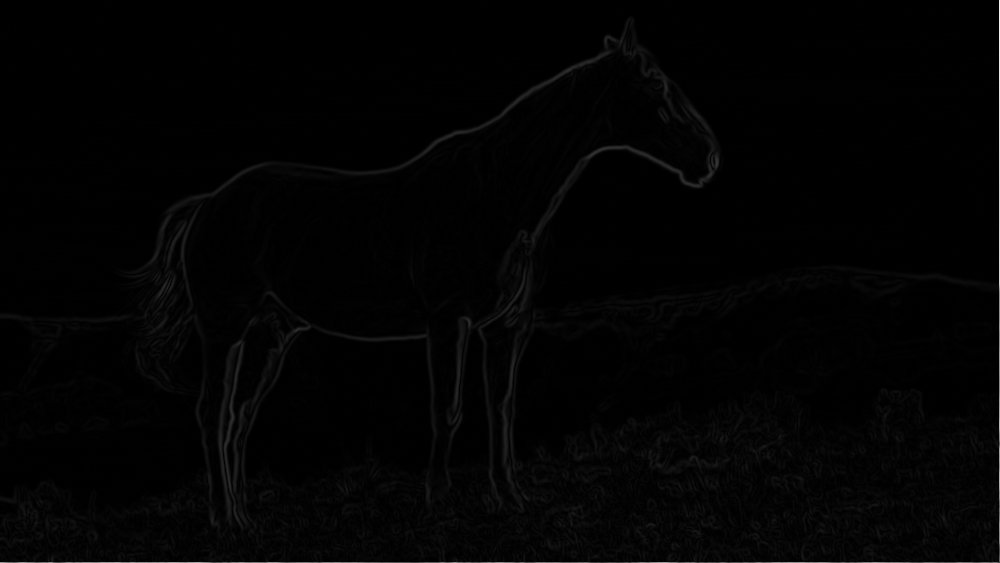

In [8]:
I.fromarray(G_arr.astype('uint8'))

As can be seen, the outline of the horse now is the only true outline showing in the image depiction of the gradient magnitude. However, this is ONLY because the values in the array are so small, and thus are not meant to show up as an image. Yet, if we multiply all the values by 20, we can see what is really going on behind the gradient magnitude array:

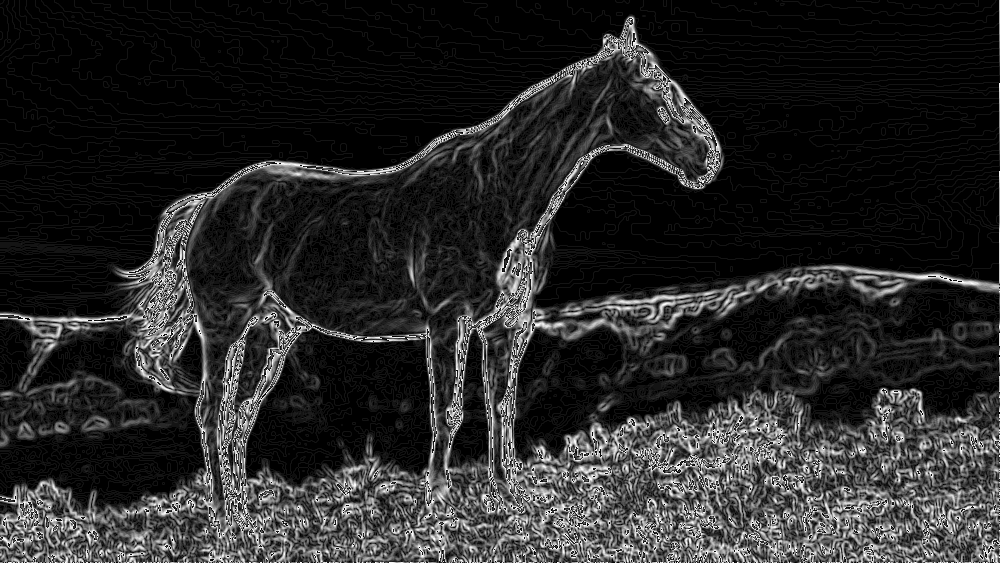

In [9]:
I.fromarray((G_arr*20).astype('uint8'))

As we can see, this shows the layers and 2D shapes present in the values in the gradient magnitude array. The body of the horse is particularly unique, in that the edges swirl, mapping more the shading of the horse than anything, but in the end having very small values in the final matrix (remember, the image above was artificially altered -- multiplied by 20 -- to visualize it better). Finally, we can see where the hard lines show up on the horse, which again define the most prominent edges in the photo.

Now, we will create a matrix calculating the gradient direction, as explained in the homework. A similar procedure will be followed as that to create the G-matrix above. Note that in the code below, warnings show divide by 0, due to the nature of the arctan function, and the possibility of the approximation of the partial derivative to equal 0. However, it simply calculates as a "NaN" value, which can then be converted to 0, as instructed in Piazza.

In [10]:
theta_arr = np.zeros(smooth_df.shape)

for i in range(padded_df.shape[0]-1):
    for j in range(padded_df.shape[1]-1):
        theta_arr[i,j]=theta(padded_df,i,j)

theta_arr = np.nan_to_num(theta_arr,0)

C:\Users\tyler\AppData\Local\Temp\ipykernel_5056\1698790912.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return math.atan(dSy(arr,i,j)/dSx(arr,i,j))
C:\Users\tyler\AppData\Local\Temp\ipykernel_5056\1698790912.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return math.atan(dSy(arr,i,j)/dSx(arr,i,j))


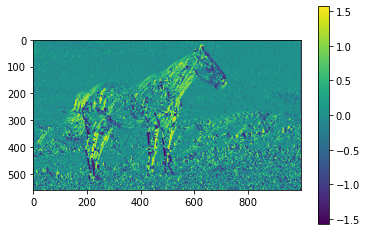

In [11]:
plt.imshow(theta_arr)
plt.colorbar()
plt.show()

Just as a way to visualize what the result was of the gradient direction calculations, I show it up above, although the values in the new theta array are not meant to be represented as pixel shades, as they range from $-\frac{1}{2}\pi$ to $\frac{1}{2}\pi$, as expected due to the arctan calculation. However, when viewed as a heatmap, we can see in the image where there are positive and negative gradient directions, which we can see mimic the shadowing and highlighting in the original image.

# Part C

Now that we have both gradient magnitude and direction calculated, we must determine the edge pixel using nonmaximal suppression, as stated in the instructions. To determine edge pixels, we can use the following function: 

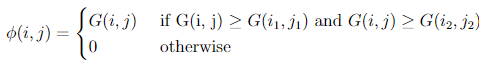

in which $(i_1,j_1)$ and $(i_2,j_2)$ refer to neighboring pixels 1 and 2. But since our pixels are in a 2D space, we must determine WHICH neighboring pixel will be used for reference, which is determiend with the following logic: 

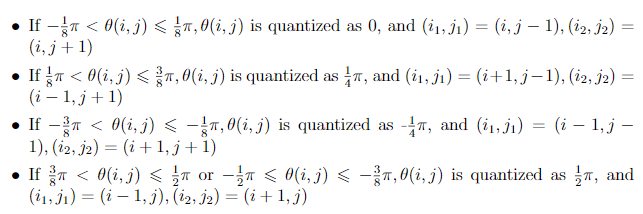

Thus, I will code this logic into a function below, which will be then used in another function to calculate phi(i,j) per pixel.

In [12]:
def quantizizer(theta_arr,i,j):
    if (theta_arr[i,j] > -(1/8)*np.pi) & (theta_arr[i,j] <= (1/8)*np.pi):
        return 0, (i,j-1), (i,j+1)
    elif (theta_arr[i,j] > (1/8)*np.pi) & (theta_arr[i,j] <= (3/8)*np.pi):
        return (1/4)*np.pi, (i+1,j-1),(i-1,j+1)
    elif (theta_arr[i,j] > -(3/8)*np.pi) & (theta_arr[i,j] <= -(1/8)*np.pi):
        return -(1/4)*np.pi, (i-1,j-1), (i+1,j+1)
    elif ((theta_arr[i,j] > (3/8)*np.pi) & (theta_arr[i,j] <= (1/2)*np.pi)) | ((theta_arr[i,j] >= -(1/2)*np.pi) & (theta_arr[i,j] <= -(3/8)*np.pi)):
        return (1/2)*np.pi, (i-1,j),(i+1,j)

In [13]:
def fi(G_arr,theta_arr,i,j):
    _,i1j1, i2j2 = quantizizer(theta_arr,i,j)
    if (G_arr[i,j] >= G_arr[i1j1[0],i1j1[1]]) & (G_arr[i,j] >= G_arr[i2j2[0],i2j2[1]]):
        return G_arr[i,j]
    else:
        return 0

In [14]:
fi_arr = np.zeros(smooth_df.shape)

for i in range(smooth_df.shape[0]-1):
    for j in range(smooth_df.shape[1]-1):
        fi_arr[i,j]=fi(G_arr,theta_arr,i,j)

Again using a similar process of calculating a new array with the phi function, I get an array, which filters our original G matrix for edge points. First, I will present the image below, but since the edges are so difficult to see (thin lines of just a single pixel with values not meant to be translated directly to shades), I will show it as a heatmap with pyplot, and then finally I will augment the values by multiplying them by 40 to see it more clearly using PILLOW package to show a clearer distinction between 0 and non-0 values.

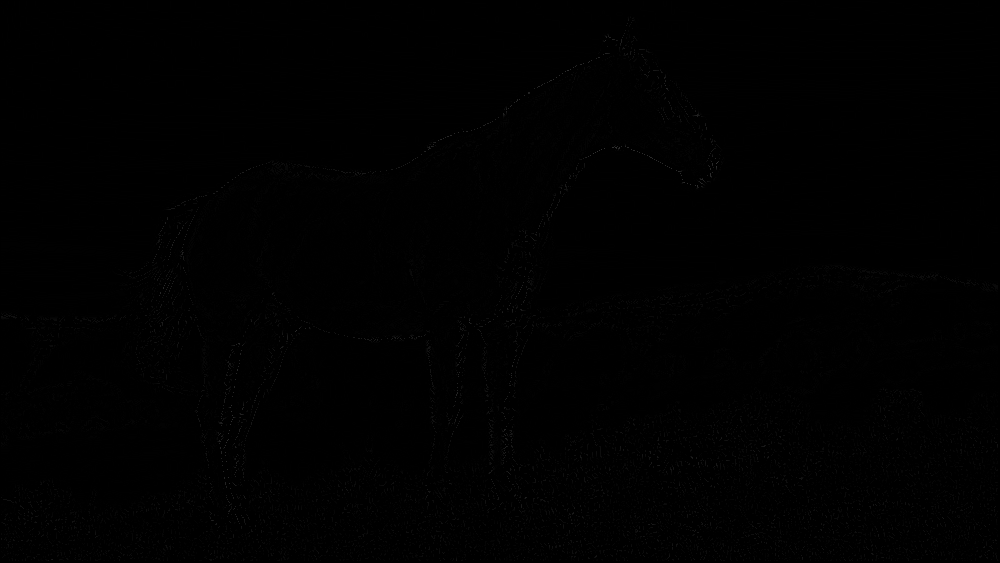

In [15]:
I.fromarray((fi_arr).astype('uint8'))

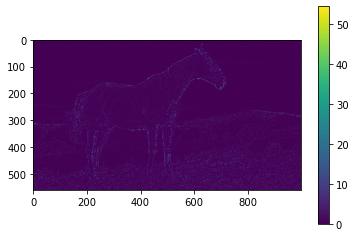

In [16]:
plt.imshow(fi_arr)
plt.colorbar()
plt.show()

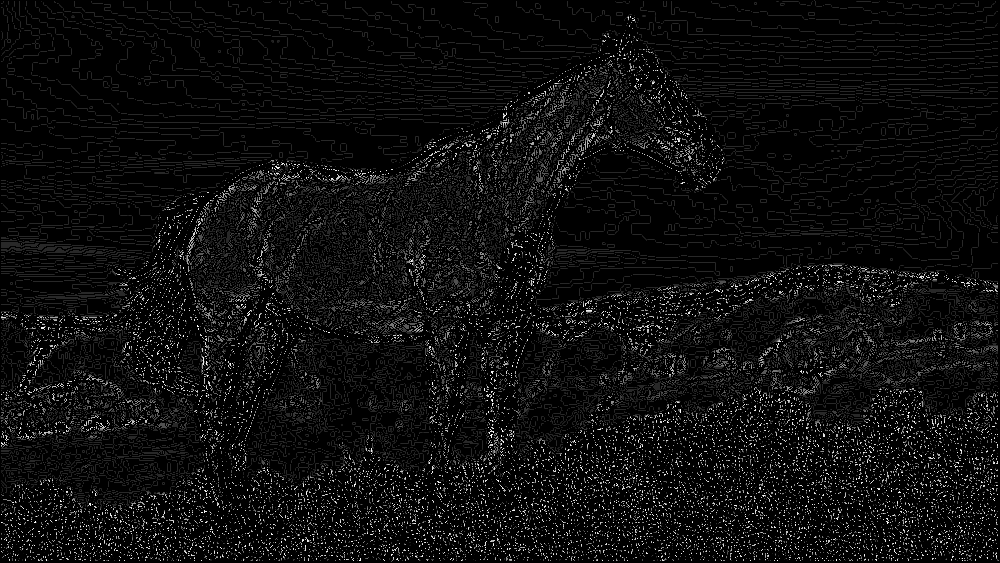

In [17]:
I.fromarray((fi_arr*40).astype('uint8'))

# Part D

Finally, as the last step, we want to reduce "streaking", in which edges are broken up due to values fluctuating along the threshold along a given edge, often caused by noise and thin textures. Thus, we can use hysteresis with two thresholds to select final edge pixels, and set them to a simple value of 1, while all other pixels are 0-shaded, thus simplifying the edges. 

To do so, we are asked to following this algorithm to calculate the final matrix: 

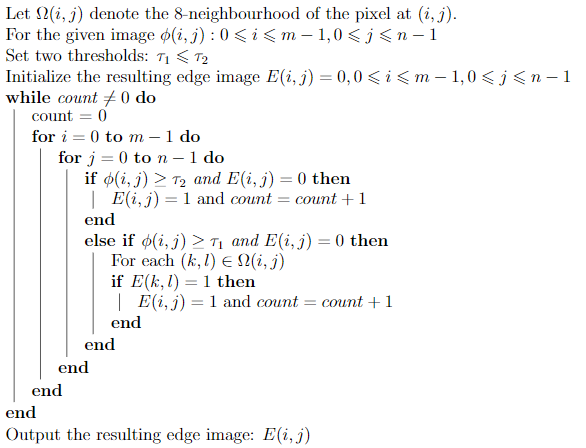

I do this in the below cell:

In [18]:
t1 = 3
t2 = 8
E = np.zeros((smooth_df.shape[0],smooth_df.shape[1]))
count = np.nan
while count != 0:
    count = 0
    for i in range(0,smooth_df.shape[0]-1):
        for j in range(0,smooth_df.shape[1]-1):
            if (fi_arr[i,j] >= t2) & (E[i,j] == 0):
                E[i,j] = 1
                count += 1
            elif (fi_arr[i,j] >= t1) & (E[i,j] == 0):
                for k in range(i-1,i+2):
                    for l in range(j-1,j+2):
                        if (k!=i) & (l!=j):
                            if E[k,l] == 1:
                                E[i,j] = 1
                                count += 1

Now, because the resulting values are only 0 and 1, just for the motivation of visualizing the final results of edge detection, I set the 1-values to 255 so they can be visualized as distinctly white, and leave the 0-valued pixels as 0:

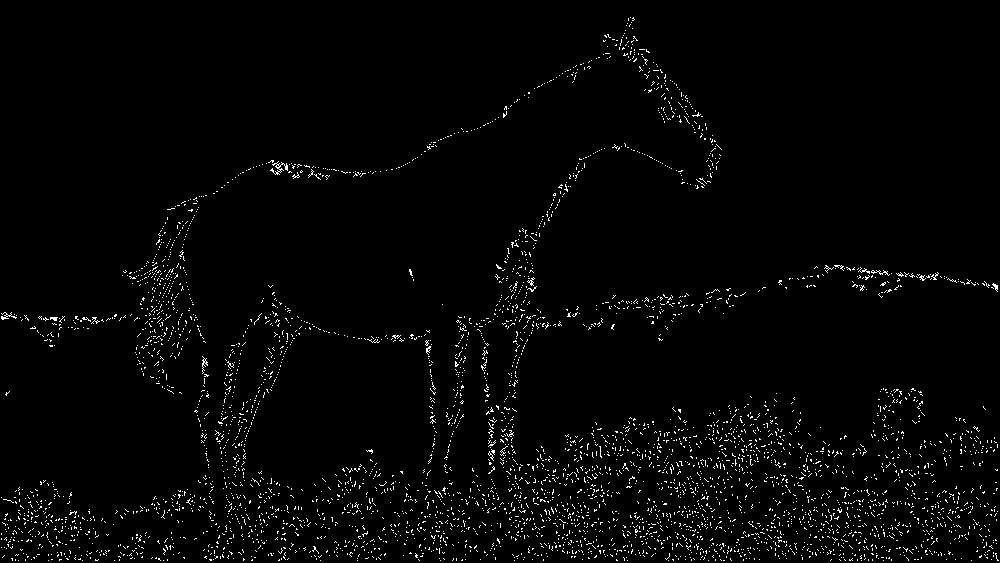

In [19]:
I.fromarray(np.where(E>0,255,E).astype('uint8'))

As we can see, the result is very thin detected edges, which only represent the most prominent "true" edges in the photo! 